# Airbnb Price Prediction Modelling

This notebook has analyzed the prices of Airbnb listings in Amsterdam and focused on different models and approaches. The metrics I use to evaluate the models is the median absolute error due to the presence of extreme outliers and skewness in the data set.To create the actual model, a suitable algorithm and respective parameters need to be chosen.I will predict the prices by using a variety of regression machine learning methodologies including random forest regression,linear regression, decision tree regression, Lasso as well as support vector regression. I tuned the model in order to get the best hyperparameters I could.   

## 1-) Import Libraries

In [1]:
#Data Processing
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression,chi2
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

## 2-) Read Data

In [2]:
df = pd.read_csv('../data/listings_preprocessed.csv')

print('Dataset has {} rows and {} columns after cleaning the outliers'.format(*df.shape))
df.sample(3)

Dataset has 18546 rows and 34 columns after cleaning the outliers


,price,accommodates,bathrooms,security_deposit,cleaning_fee,amenities_number,neighbourhood_Bijlmer-Centrum,neighbourhood_Bijlmer-Oost,neighbourhood_Bos en Lommer,neighbourhood_Buitenveldert - Zuidas,...,neighbourhood_Slotervaart,neighbourhood_Watergraafsmeer,neighbourhood_Westerpark,neighbourhood_Zuid,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,property_type_Apartment,property_type_House,property_type_Other
4356,130,4,1.0,0.0,20.0,45,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
16159,180,4,1.5,0.0,50.0,16,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
1688,270,1,1.0,0.0,0.0,13,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


## 3-) Pre-processing for modelling

In this part I will select the best features to train the model both manually from a heatmap and using SelectKBest, f_regression. Let's select first manually from a correlation heatmap.

### 3.1 Selecting the best features for the regression manually b Correlation Heatmap

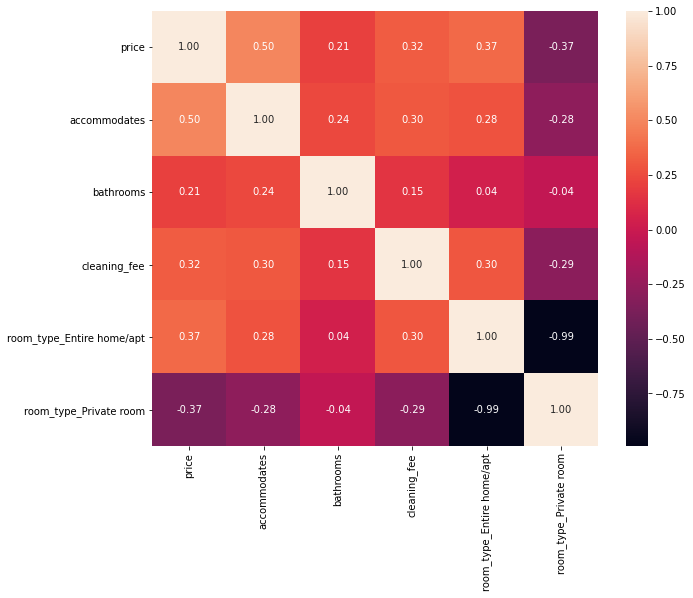

In [4]:
# Find the columns highly correlated with the price neagatively or positively. 
cols_to_heatmap = df.corr().loc[(df.corr().price > 0.2) | (df.corr().price < -0.2)].index

#Plot the correlation
plt.figure(figsize=(10,8))
sns.heatmap(df[cols_to_heatmap].corr(),cbar=True, annot=True, fmt='.2f')
plt.show()

It is obviously seen from the plot that price has correlated highly with the roomtype, cleaning fee, numbers of bathroom and accomodates as well. Therefore, I will chose the 5 features above to train my model.

In [5]:
#The important features that will be used for training the model by the X(columns to train) datasets.
cols_to_train = ['accommodates','bathrooms','cleaning_fee','room_type_Entire home/apt', 'room_type_Private room']

### 3.2 Data Splitting: Features / labels - Training set / testing set

I split my dataframe into features and labels and training and testing sets.

In [6]:
X = df.drop(['price'],axis =1)
y = df['price']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.20)

I will create the first training and test datasets with selected features by heatmap above.

In [8]:
X_train_corr = X_train[cols_to_train]
X_test_corr = X_test[cols_to_train]

### 3.3 Selecting the best features for the regression by SelectKBest, f_regression

Now it is time to use SelectKbest from scikit-learn to select best features to train model for the modelling part.

<AxesSubplot:>

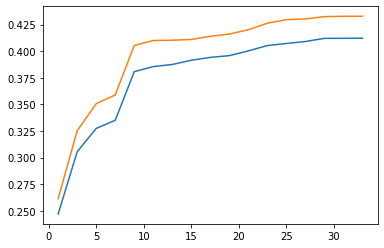

In [9]:
column_names = df.drop(columns = ['price']).columns

no_of_features = []
r_squared_train = []
r_squared_test = []

for k in range(1,34,2):
    selector = SelectKBest(f_regression, k = k)
    X_train_transformed = selector.fit_transform(X_train, y_train)
    X_test_transformed = selector.transform(X_test)
    regressor = LinearRegression()
    regressor.fit(X_train_transformed, y_train)
    no_of_features.append(k)
    r_squared_train.append(regressor.score(X_train_transformed, y_train))
    r_squared_test.append(regressor.score(X_test_transformed, y_test))

sns.lineplot(x = no_of_features, y = r_squared_train, legend = 'full')
sns.lineplot(x = no_of_features, y = r_squared_test, legend = 'full')


It is obviously seen in the plot above max score is reached around 25 features. I will get those 25 features to train the model.

In [10]:
selector = SelectKBest(f_regression, k = 25)
X_train_transformed = selector.fit_transform(X_train, y_train.values.ravel())
X_test_transformed = selector.transform(X_test)
print(column_names[selector.get_support()])

Index(['accommodates', 'bathrooms', 'security_deposit', 'cleaning_fee',
       'amenities_number', 'neighbourhood_Bijlmer-Centrum',
       'neighbourhood_Bijlmer-Oost', 'neighbourhood_Bos en Lommer',
       'neighbourhood_Centrum-Oost', 'neighbourhood_Centrum-West',
       'neighbourhood_De Aker - Nieuw Sloten',
       'neighbourhood_De Pijp - Rivierenbuurt',
       'neighbourhood_Gaasperdam - Driemond',
       'neighbourhood_Geuzenveld - Slotermeer', 'neighbourhood_Noord-Oost',
       'neighbourhood_Noord-West',
       'neighbourhood_Oostelijk Havengebied - Indische Buurt',
       'neighbourhood_Osdorp', 'neighbourhood_Slotervaart',
       'neighbourhood_Zuid', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'property_type_Apartment', 'property_type_House'],
      dtype='object')


The columns above in the list are the important features that will be used for training the model. I will use those features for my second X(columns to train). Transformed datasets contain the features are selected by SelectKBest while Corr datasets contain the features that are selected manually from the correlation heatmap. Let's check the shape of both datasets.

In [12]:
print('Transformed training dataset contains {} rows and {} columns'.format(*X_train_transformed.shape))
print('Transformed test dataset contains {} rows and {} columns'.format(*X_test_transformed.shape))
print('Corr training dataset contains {} rows and {} columns'.format(*X_train_corr.shape))
print('Corr test dataset contains {} rows and {} columns'.format(*X_test_corr.shape))

Transformed training dataset contains 14836 rows and 25 columns
Transformed test dataset contains 3710 rows and 25 columns
Corr training dataset contains 14836 rows and 5 columns
Corr test dataset contains 3710 rows and 5 columns


I will use 5 features for the first corr training dataset while using 25 features for the transformed dataset selected by SelectKBest.

## 4-) Modelling

Now that the data preprocessing is over, I can start the second part of this work: applying different Machine Learning models. As a reminder, I decided to apply 5 different models from the Scikit-learn library:
* Random Forest, with the RandomForestRegressor
* Linear regression with the LinearRegression 
* Decision tree regression, with the DecisionTreeRegressor 
* Lasso, with the linear.model.Lasso 
* Support Vector Regression, with the SVR 

Each time, I applied the model with its default hyperparameters and I then tuned the model in order to get the best hyperparameters I could. The metrics I use to evaluate the models are R2 score, median absolute error and RMSE due to the presence of extreme outliers and skewness in the data set.
Let's start with the Random Forest model.


### 4.1 How to evaluate the models

I will create a method that evaluates the performance of the model.The testing set will be evaluated by the model;
* I use r-square (R2) as my performance score, which measures the strength of the relationship between the model and the dependent variable on a scale of 0 to 1 and indicates the percentage of variance in the target variable that can be explained by the model. R2 score  is “(total variance explained by model) / total variance.” So if it is 100%, the two variables are perfectly correlated, i.e., with no variance at all. A low value would show a low level of correlation, meaning a regression model that is not valid, but not in all cases.


* I also decide to have a look at the root-mean-square error (RMSE) and the median absolute error(MAE) to measure the performance of the model

    - RMSE is a method of measuring the difference between values predicted by a model and their actual values.It also measures the standard deviation of residuals. Usually, a RMSE score of less than 180 is considered a good score for a moderately or well working algorithm.
    
    - MAE the median absolute error, which is useful. I prefer median absolute error to mean absolute error because the former is less sensitive to a few anomalous outliers. 

In [13]:
def evaluate_model(model, predict_set, evaluate_set):
    predictions = model.predict(predict_set)
    print("r2 score: " + str(round(r2_score(evaluate_set,predictions), 2)))
    print("Median Absolute Error: " + str(round(median_absolute_error(predictions, evaluate_set), 2)))  
    RMSE = round(sqrt(mean_squared_error(predictions, evaluate_set)), 2)
    print("RMSE: " + str(RMSE)) 

### 4.2 Hyperparameters tuning

I can improve the results of default hyperparameters with some hypermarameter tuning. There are two main methods available for this:
* Random Search
* Grid Search

It is required ti provide a parameter grid to these methods. Then, they both try different combinations of parameters within the provided grid. But the first one only tries several combinations randomly whereas the second one tries all the possible combinations with the grid you provided. 


I start with a random search to roughly evaluate a good combination of parameters. Once this is done, I use the grid search to get more precise results.



### 4.3 Application of the Random Forest Regressor

As I said, the first algorithm I apply is a Random Forest regressor with the default hyperparameters.

#### 4.3.1 With default hyperparameters

I create a pipeline that first scales the data, then applies the model. Finally, I fit this pipeline to the training set.

In [14]:
# Create the pipeline (scaler + regressor)
pipeline_RF_transformed = make_pipeline(StandardScaler(),
                                        RandomForestRegressor(random_state=42))

pipeline_RF_corr = make_pipeline(StandardScaler(),
                                 RandomForestRegressor(random_state=42))
# Fit the model
pipeline_RF_transformed.fit(X_train_transformed, y_train)
pipeline_RF_corr.fit(X_train_corr,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

#### 4.3.2 Evaluation

In [20]:
print('Results for TRANSFORMED dataset:')
result_RF_transformed = evaluate_model(pipeline_RF_transformed, X_test_transformed, y_test)
result_RF_transformed
print('\nResults for CORR dataset:')
result_RF_corr = evaluate_model(pipeline_RF_corr, X_test_corr, y_test)
result_RF_corr

Results by 25 features:
r2 score: 0.34
Median Absolute Error: 25.5
RMSE: 43.07

Results by 5 features:
r2 score: 0.35
Median Absolute Error: 25.44
RMSE: 42.53


These first results with default hyperparameters are slightly different. The train dataset corr is better than the transformed one.

#### 4.3.3 Hyperparameters tuning

I had almost similiar results with the default hyperparameters of the Random Forest regressor. But I can improve the results with some hyperparameter tuning.

### -Randomized Search with Cross Validation

##### a-) Creation of the parameter grid

In [22]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
               'randomforestregressor__min_samples_split': min_samples_split,
               'randomforestregressor__min_samples_leaf': min_samples_leaf,
               'randomforestregressor__bootstrap': bootstrap}

##### b-) Search for best hyperparameters

In [24]:
from sklearn.model_selection import RandomizedSearchCV

# Random search of parameters, using 2 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_transformed = RandomizedSearchCV(estimator = pipeline_RF_transformed, 
                               param_distributions = random_grid, 
                               n_iter = 50, cv = 2, verbose=2,
                               random_state = 42, n_jobs = -1, 
                               scoring = ['r2','neg_median_absolute_error'], refit = 'r2')
rf_random_corr = RandomizedSearchCV(estimator = pipeline_RF_corr, 
                               param_distributions = random_grid, 
                               n_iter = 50, cv = 2, verbose=2,
                               random_state = 42, n_jobs = -1, 
                               scoring = ['r2','neg_median_absolute_error'], refit = 'r2')

In [30]:
rf_random_transformed.fit(X_train_transformed, y_train)
print('Best parameters for the TRANSFORMED dataset Random Forest Regressor random search:\n'+ str(rf_random_transformed.best_params_))
rf_random_corr.fit(X_train_corr, y_train)
print('\nBest parameters for the CORR dataset Random Forest Regressor random search:\n'+ str(rf_random_corr.best_params_))

Best parameters for the TRANSFORMED dataset Random Forest Regressor random search:
{'randomforestregressor__n_estimators': 1000, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_depth': 110, 'randomforestregressor__bootstrap': True}

Best parameters for the CORR dataset Random Forest Regressor random search:
{'randomforestregressor__n_estimators': 875, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_depth': 10, 'randomforestregressor__bootstrap': True}


### *-Grid Search with Cross Validation*

##### a-) Creation of the parameter grid

In [31]:
# Create the parameter grid based on the results of random search 
param_grid_transformed = {
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__max_depth': [100, 110,120], 
    'randomforestregressor__max_features': ['sqrt'],
    'randomforestregressor__min_samples_leaf': [2],
    'randomforestregressor__min_samples_split': [5],
    'randomforestregressor__n_estimators': [800, 900, 1000]  
}
param_grid_corr = {
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__max_depth': [90, 100, 110,120], 
    'randomforestregressor__max_features': ['sqrt'],
    'randomforestregressor__min_samples_leaf': [2],
    'randomforestregressor__min_samples_split': [2],
    'randomforestregressor__n_estimators': [800,875, 900]  
}

##### b-) Search for best hyperparameters

In [33]:
# Instantiate the grid search model
grid_search_transformed = GridSearchCV(estimator = pipeline_RF_transformed, 
                           param_grid = param_grid_transformed, 
                           cv = 5, n_jobs = -1, verbose = 2, 
                           scoring = ['r2','neg_median_absolute_error'], refit = 'r2')

grid_search_corr = GridSearchCV(estimator = pipeline_RF_corr, 
                           param_grid = param_grid_corr, 
                           cv = 5, n_jobs = -1, verbose = 2, 
                           scoring = ['r2','neg_median_absolute_error'], refit = 'r2')

# Fit the grid search to the data
grid_search_transformed.fit(X_train_transformed, y_train)

grid_search_corr.fit(X_train_corr, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.2min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__bootstrap': [True],
                         'randomforestregressor__max_depth': [90, 100, 110,
                                                              120],
                         'randomforestregressor__max_features': ['sqrt'],
                         'randomforestregressor__min_samples_leaf': [2],
                         'randomforestregressor__min_samples_split': [2],
                         'randomforestregressor__n_estimators': [800, 875,
                                                                 900]},
             refit='r2', scoring=['r2', 'neg_median_absolute_error'],
             verbose=2)

In [34]:
print('Transformed train dataset best params: \n' + str(grid_search_transformed.best_params_))

Transformed train dataset best params: 
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 100, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 1000}


In [35]:
print('Corr train dataset best params: \n' + str(grid_search_corr.best_params_))


Corr train dataset best params: 
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 90, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 900}


For my Random Forest regressor I observed the following optimal parameters according to my grid search:

* Using the maximum depth of tree is 100 for the transformed train dataset while 90 for the corr train dataset as the best degree out of numbers (90,100,110,120).
* Using the number of trees in the forest is 1000 for the transformed train dataset whereas 900 for the corr train dataset was chosen as the best degree out of numbers (800, 875, 900, 1000).


***c-) Evaluation of the model***

In [36]:
pipeline_transformed_RF_grid = make_pipeline(  RandomForestRegressor(random_state=42,
                                                            bootstrap = True,
                                                            max_depth = 100,
                                                            max_features = 'sqrt',
                                                            min_samples_leaf = 2,
                                                            min_samples_split = 5,
                                                            n_estimators = 1000))
pipeline_corr_RF_grid = make_pipeline(  RandomForestRegressor(random_state=42,
                                                            bootstrap = True,
                                                            max_depth = 90,
                                                            max_features = 'sqrt',
                                                            min_samples_leaf = 2,
                                                            min_samples_split = 2,
                                                            n_estimators = 900))

# Fit the models
pipeline_transformed_RF_grid.fit(X_train_transformed, y_train)
pipeline_corr_RF_grid.fit(X_train_corr, y_train)

Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(max_depth=90, max_features='sqrt',
                                       min_samples_leaf=2, n_estimators=900,
                                       random_state=42))])

In [42]:
print('Results of tuned TRANSFORMED dataset:')
result_transformed_RF_tuned_test = evaluate_model(pipeline_transformed_RF_grid,X_test_transformed, y_test)
result_transformed_RF_tuned_test
print('\nResults of default TRANSFORMED dataset:')
result_transformed_RF_test = evaluate_model(pipeline_RF_transformed, X_test_transformed, y_test)
result_transformed_RF_test

Results of tuned TRANSFORMED dataset:
r2 score: 0.44
Median Absolute Error: 23.89
RMSE: 39.45

Results of default TRANSFORMED dataset:
r2 score: 0.34
Median Absolute Error: 25.5
RMSE: 43.07


In [43]:
print('Results of tuned CORR dataset:')
result_corr_RF_tuned_test = evaluate_model(pipeline_corr_RF_grid,X_test_corr, y_test)
result_corr_RF_tuned_test
print('\nResults of default CORR dataset:')
result_corr_RF_test = evaluate_model(pipeline_RF_corr, X_test_corr, y_test)
result_corr_RF_test

Results of tuned CORR dataset:
r2 score: 0.37
Median Absolute Error: 25.51
RMSE: 42.04

Results of default CORR dataset:
r2 score: 0.35
Median Absolute Error: 25.44
RMSE: 42.53


I get better results with the tuned model than with default hyperparameters. The transformed dataset(contains best 25 features) did better precision than the corr dataset(contains best 5 features) for the tuned Random Forest Regressor.

### 4.4 Application of the Linear Regression model 

**4.4.1 With default hyperparameters**

I create a pipeline that first scales the data, then applies the model. Finally, I fit this pipeline to the training set.

In [44]:
# Create the pipeline (regressor)
pipeline_transformed_LM = make_pipeline(StandardScaler(),
                                        LinearRegression())

pipeline_corr_LM = make_pipeline(StandardScaler(),
                                 LinearRegression())
# Fit the models
pipeline_transformed_LM.fit(X_train_transformed, y_train)
pipeline_corr_LM.fit(X_train_corr, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

**4.4.2 Evaluation**

In [45]:
print('Results for TRANSFORMED dataset:')
result_transformed_LM = evaluate_model(pipeline_transformed_LM, X_test_transformed, y_test)
result_transformed_LM
print('\nResults for CORR dataset:')
result_corr_LM = evaluate_model(pipeline_corr_LM, X_test_corr, y_test)
result_corr_LM

Results for TRANSFORMED dataset:
r2 score: 0.43
Median Absolute Error: 24.36
RMSE: 39.9

Results for CORR dataset:
r2 score: 0.35
Median Absolute Error: 26.54
RMSE: 42.59


The results with default hyperparameters are higher than Randomforest Regression results by default hyperparameters. It is time for tuning the hyperparameters to get better results. Transformed dataset has higher precision score than Corr dataset.

#### 4.3.3 Hyperparameters tuning

### -Randomized Search with Cross Validation

##### a-)Creation of the parameter grid

In [46]:
# Whether to calculate the intercept for this model
intercept = [True, False]
# Whether the regressors X will be normalized before regression 
normalize = [True, False]
# The number of jobs to use for the computation.
n_jobs = [int(x) for x in np.linspace(-1, 110, num = 5)]

# Create the random grid
random_grid = {'linearregression__fit_intercept': intercept,
               'linearregression__normalize': normalize,
               'linearregression__n_jobs': n_jobs}

##### b-) Search for best hyperparameters

In [47]:
# Random search of parameters, using 5 fold cross validation, 
# search across 250 different combinations, and use all available cores
LM_random_transformed = RandomizedSearchCV(estimator = pipeline_transformed_LM, 
                               param_distributions = random_grid, 
                                cv = 5,
                               scoring = ['neg_median_absolute_error','r2'], refit = 'r2')
LM_random_corr = RandomizedSearchCV(estimator = pipeline_corr_LM, 
                               param_distributions = random_grid, 
                                cv = 5,
                               scoring = ['neg_median_absolute_error','r2'], refit = 'r2')

In [68]:
# LM_random_transformed.fit(X_train_transformed, y_train)
print('Best parameters for the TRANSFORMED dataset Linear Regressor random search:\n'+ str(LM_random_transformed.best_params_))
# LM_random_corr.fit(X_train_corr, y_train)
print('\nBest parameters for the CORR dataset Linear Regressor random search:\n'+ str(LM_random_corr.best_params_))

Best parameters for the TRANSFORMED dataset Linear Regressor random search:
{'linearregression__normalize': False, 'linearregression__n_jobs': 26, 'linearregression__fit_intercept': True}

Best parameters for the CORR dataset Linear Regressor random search:
{'linearregression__normalize': True, 'linearregression__n_jobs': 82, 'linearregression__fit_intercept': True}


### -Grid Search with Cross Validation

##### a-) Creation of the parameter grid

In [52]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'linearregression__fit_intercept' : [False,True],
    'linearregression__normalize': [True,False], 
    'linearregression__n_jobs': [-1,26,82,100,None],
}


##### b-) Search for best hyperparameters

In [56]:
# Instantiate the grid search model
grid_search_transformed = GridSearchCV(estimator = pipeline_transformed_LM, 
                           param_grid = param_grid, 
                           cv = 5, 
                           scoring = ['neg_median_absolute_error','r2'],
                           refit = 'r2')

grid_search_corr = GridSearchCV(estimator = pipeline_corr_LM, 
                           param_grid = param_grid, 
                           cv = 5, 
                           scoring = ['neg_median_absolute_error','r2'],
                           refit = 'r2')

# Fit the grid search to the data
grid_search_transformed.fit(X_train_transformed, y_train)

grid_search_corr.fit(X_train_corr, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [False, True],
                         'linearregression__n_jobs': [-1, 26, 82, 100, None],
                         'linearregression__normalize': [True, False]},
             refit='r2', scoring=['neg_median_absolute_error', 'r2'])

In [57]:
print('Transformed train dataset best params: \n' + str(grid_search_transformed.best_params_))

Transformed train dataset best params: 
{'linearregression__fit_intercept': True, 'linearregression__n_jobs': -1, 'linearregression__normalize': False}


In [58]:
print('Corr train dataset best params: \n' + str(grid_search_corr.best_params_))

Corr train dataset best params: 
{'linearregression__fit_intercept': True, 'linearregression__n_jobs': -1, 'linearregression__normalize': True}


For my Linear Regression I observed the following optimal parameters according to my grid search:
* Intercept will be calculated for the both train datasets.
* Using all precessors with n_jobs = -1.
* Setting normalize true to the regressors X will be normalized before regression by subtracting the mean for the corr train dataset whereas setting normalize false for the transformed train dataset.

***c-) Evaluation of the model***

In [59]:
pipeline_transformed_LM_grid = make_pipeline(LinearRegression(fit_intercept= True,
                                                     normalize = False,
                                                     n_jobs = -1))
pipeline_corr_LM_grid = make_pipeline(LinearRegression(fit_intercept= True,
                                                     normalize = True,
                                                     n_jobs = -1))

# Fit the models
pipeline_transformed_LM_grid.fit(X_train_transformed, y_train)
pipeline_corr_LM_grid.fit(X_train_corr, y_train)

Pipeline(steps=[('linearregression',
                 LinearRegression(n_jobs=-1, normalize=True))])

In [61]:
print('Results of tuned TRANSFORMED dataset:')
result_transformed_LM_tuned_test = evaluate_model(pipeline_transformed_LM_grid,X_test_transformed, y_test)
result_transformed_LM_tuned_test
print('\nResults of default TRANSFORMED dataset:')
result_transformed_LM_test = evaluate_model(pipeline_transformed_LM, X_test_transformed, y_test)
result_transformed_LM_test

Results of tuned TRANSFORMED dataset:
r2 score: 0.43
Median Absolute Error: 24.36
RMSE: 39.91

Results of default TRANSFORMED dataset:
r2 score: 0.43
Median Absolute Error: 24.36
RMSE: 39.9


In [62]:
print('Results of tuned CORR dataset:')
result_corr_LM_tuned_test = evaluate_model(pipeline_corr_LM_grid,X_test_corr, y_test)
result_corr_LM_tuned_test
print('\nResults of default CORR dataset:')
result_corr_LM_test = evaluate_model(pipeline_corr_LM, X_test_corr, y_test)
result_corr_LM_test

Results of tuned CORR dataset:
r2 score: 0.35
Median Absolute Error: 26.54
RMSE: 42.59

Results of default CORR dataset:
r2 score: 0.35
Median Absolute Error: 26.54
RMSE: 42.59


Nothing has changed by tuning the Linear Regression. I get the same result with both default and tuned hyperparameters.

### 4.5 Application of the Decision Tree Regression model

#### 4.5.1 With default hyperparameters

I create a pipeline that first scales the data, then applies the model. Finally, I fit this pipeline to the training set.

In [63]:
from sklearn.tree import DecisionTreeRegressor
# Create the pipeline (scaler + regressor)
pipeline_transformed_DTR = make_pipeline(StandardScaler(),
                                         DecisionTreeRegressor())
pipeline_corr_DTR = make_pipeline(StandardScaler(),
                                         DecisionTreeRegressor())

# Fit the models
pipeline_transformed_DTR.fit(X_train_transformed, y_train)
pipeline_corr_DTR.fit(X_train_corr, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor())])

**4.5.2 Evaluation**

In [64]:
print('Results for TRANSFORMED dataset:')
result_transformed_DTR = evaluate_model(pipeline_transformed_DTR, X_test_transformed, y_test)
result_transformed_DTR
print('\nResults for CORR dataset:')
result_corr_DTR = evaluate_model(pipeline_corr_DTR, X_test_corr, y_test)
result_corr_DTR

Results for TRANSFORMED dataset:
r2 score: -0.1
Median Absolute Error: 30.0
RMSE: 55.39

Results for CORR dataset:
r2 score: 0.33
Median Absolute Error: 25.55
RMSE: 43.24


The precision score is terrifying for the Transformed dataset whereas normal for the corr dataset. Let's try to tune the decision tree, maybe the default parameters are not good for datasets.

#### 4.5.3 Hyperparameters tuning

### -Randomized Search with Cross Validation

##### a-) Creation of the parameter grid

In [65]:
#The function to measure the quality of a split.
criterion = ['mse','friedman_mse','mae','poisson']
#The maximum depth of the tree.
max_depth = [int(x) for x in np.linspace(0, 110, num = 5)]
#The strategy used to choose the split at each node.
splitter =['random', 'best']
#Controls the randomness of the estimator.
random_states = [None, 1, 42]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Create the random grid
random_grid = {
    'decisiontreeregressor__criterion' : criterion,
    'decisiontreeregressor__max_depth': max_depth, 
    'decisiontreeregressor__splitter': splitter,
    'decisiontreeregressor__random_state': random_states,
    'decisiontreeregressor__min_samples_leaf': min_samples_leaf,
    'decisiontreeregressor__min_samples_split' : min_samples_split
}

##### b-) Search for best hyperparameters

In [66]:
# Random search of parameters, using 2 fold cross validation, 
# search across 100 different combinations, and use all available cores
DTR_random_transformed = RandomizedSearchCV(estimator = pipeline_transformed_DTR, 
                                            param_distributions = random_grid, 
                                            n_iter = 50, cv = 2, verbose=2,
                                            n_jobs = -1, 
                                            scoring = ['neg_median_absolute_error','r2'],
                                            refit = 'r2')
DTR_random_corr = RandomizedSearchCV(estimator = pipeline_corr_DTR, 
                                            param_distributions = random_grid, 
                                            n_iter = 50, cv = 2, verbose=2,
                                            n_jobs = -1, 
                                            scoring = ['neg_median_absolute_error','r2'],
                                            refit = 'r2')


In [75]:
DTR_random_transformed.fit(X_train_transformed, y_train)
print('Best parameters for the TRANSFORMED dataset Decision Tree Regressor random search:\n\n'+ str(DTR_random_transformed.best_params_))

Best parameters for the TRANSFORMED dataset Decision Tree Regressor random search:

{'decisiontreeregressor__splitter': 'random', 'decisiontreeregressor__random_state': 1, 'decisiontreeregressor__min_samples_split': 2, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__max_depth': 55, 'decisiontreeregressor__criterion': 'friedman_mse'}


In [74]:
DTR_random_corr.fit(X_train_corr, y_train)
print('Best parameters for the CORR dataset Decision Tree Regressor random search:\n\n'+ str(DTR_random_corr.best_params_))

Best parameters for the CORR dataset Decision Tree Regressor random search:

{'decisiontreeregressor__splitter': 'random', 'decisiontreeregressor__random_state': 1, 'decisiontreeregressor__min_samples_split': 2, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__max_depth': 55, 'decisiontreeregressor__criterion': 'friedman_mse'}


**Grid Search with Cross Validation**

***a-) Creation of the parameter grid***

In [80]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'decisiontreeregressor__criterion' : ['mae', 'friedman_mse'],
    'decisiontreeregressor__max_depth': [10, 60, 100], 
    'decisiontreeregressor__splitter': ['random'],
    'decisiontreeregressor__min_samples_leaf' : [1, 4],
    'decisiontreeregressor__min_samples_split' : [2, 4],
}


***b-) Search for best hyperparameters***

In [81]:
# Instantiate the grid search model
grid_search_transformed = GridSearchCV(estimator = pipeline_transformed_DTR, 
                           param_grid = param_grid, 
                           cv = 5,verbose = 2, 
                           scoring = ['neg_median_absolute_error','r2'],
                            refit = 'r2')

grid_search_corr =  GridSearchCV(estimator = pipeline_corr_DTR, 
                           param_grid = param_grid,
                           cv = 5,verbose = 2, 
                           scoring = ['neg_median_absolute_error','r2'],
                            refit = 'r2')

# Fit the grid search to the data
grid_search_transformed.fit(X_train_transformed, y_train)

grid_search_corr.fit(X_train_corr, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random, total=   7.7s
[CV] decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV]  decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random, total=   7.2s
[CV] decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random 
[CV]  decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random, total=   8.5s
[CV] decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random 
[CV]  decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregres

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random, total=   1.6s
[CV] decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random, total=   2.1s
[CV] decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random 
[CV]  decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random, total=   1.7s
[CV] decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__splitter=random 
[CV]  decisiontreeregressor__criterion=mae, decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_leaf=1, decisiontreeregres

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__criterion': ['mae',
                                                              'friedman_mse'],
                         'decisiontreeregressor__max_depth': [10, 60, 100],
                         'decisiontreeregressor__min_samples_leaf': [1, 4],
                         'decisiontreeregressor__min_samples_split': [2, 4],
                         'decisiontreeregressor__splitter': ['random']},
             refit='r2', scoring=['neg_median_absolute_error', 'r2'],
             verbose=2)

In [82]:
print('Transformed train dataset best params: \n' + str(grid_search_transformed.best_params_))

Transformed train dataset best params: 
{'decisiontreeregressor__criterion': 'friedman_mse', 'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 2, 'decisiontreeregressor__splitter': 'random'}


In [83]:
print('Corr train dataset best params: \n' + str(grid_search_corr.best_params_))

Corr train dataset best params: 
{'decisiontreeregressor__criterion': 'friedman_mse', 'decisiontreeregressor__max_depth': 100, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 4, 'decisiontreeregressor__splitter': 'random'}


For my Decision Tree I observed the following optimal parameters according to my grid search:

* Using “friedman_mse”, which uses mean squared error with Friedman’s improvement score for potential splits,
* Using 10 on the transformed and 100 on the corr train datasets for maximum depth of the tree.
* Setting minumum number of samples as 4 the minumum number from among the range(2,4).
* The minumum number of samples required to be at a leaf node is 2 on the transformed and 4 on the corr train datasets  from among the numbers(1,5,10)
* Random_state to control the randomness of the estimator will be set to 1.
* Using the default 'random' splitter to choose the best random split.


***c-) Evaluation of the model***

In [85]:
pipeline_transformed_DTR_grid = make_pipeline(StandardScaler(),
                                    DecisionTreeRegressor( criterion = 'friedman_mse',
                                                         max_depth = 10,
                                                         random_state = 1,
                                                         min_samples_leaf = 4,
                                                         min_samples_split = 2,
                                                         splitter = 'random'))
pipeline_corr_DTR_grid = make_pipeline(StandardScaler(),
                                    DecisionTreeRegressor( criterion = 'friedman_mse',
                                                         max_depth = 100,
                                                         random_state = 1,
                                                         min_samples_leaf = 4,
                                                         min_samples_split = 4,
                                                         splitter = 'random'))

# Fit the model
pipeline_transformed_DTR_grid.fit(X_train_transformed, y_train)
pipeline_corr_DTR_grid.fit(X_train_corr, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(criterion='friedman_mse', max_depth=100,
                                       min_samples_leaf=4, min_samples_split=4,
                                       random_state=1, splitter='random'))])

In [86]:
print('Results of tuned TRANSFORMED dataset:')
result_transformed_DTR_tuned_test = evaluate_model(pipeline_transformed_DTR_grid,X_test_transformed, y_test)
result_transformed_DTR_tuned_test
print('\nResults of default TRANSFORMED dataset:')
result_transformed_DTR_test = evaluate_model(pipeline_transformed_DTR, X_test_transformed, y_test)
result_transformed_DTR_test

Results of tuned TRANSFORMED dataset:
r2 score: 0.4
Median Absolute Error: 24.42
RMSE: 41.05

Results of default TRANSFORMED dataset:
r2 score: -0.1
Median Absolute Error: 30.0
RMSE: 55.39


In [87]:
print('Results of tuned CORR dataset:')
result_corr_DTR_tuned_test = evaluate_model(pipeline_corr_DTR_grid,X_test_corr, y_test)
result_corr_DTR_tuned_test
print('\nResults of default CORR dataset:')
result_corr_DTR_test = evaluate_model(pipeline_corr_DTR, X_test_corr, y_test)
result_corr_DTR_test

Results of tuned CORR dataset:
r2 score: 0.37
Median Absolute Error: 25.6
RMSE: 41.93

Results of default CORR dataset:
r2 score: 0.33
Median Absolute Error: 25.55
RMSE: 43.24


The tuned Decision Tree is much better than the one with default hyperparameters. However, it is not a strong precision as high as previous models.

### 4.6 Application of the Lasso model

**4.6.1 With the default hyperparameters**

I create a pipeline that first scales the data, then applies the model. Finally, I fit this pipeline to the training set.

In [88]:
from sklearn.linear_model import Lasso
# Create the pipeline (scaler + regressor)
pipeline_transformed_Lasso = make_pipeline( StandardScaler(),
                                            Lasso())
pipeline_corr_Lasso = make_pipeline( StandardScaler(),
                                            Lasso())
# Fit the models
pipeline_transformed_Lasso.fit(X_train_transformed, y_train)
pipeline_corr_Lasso.fit(X_train_corr, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())])

**4.6.2 Evaluation**

In [89]:
print('Results for TRANSFORMED dataset:')
result_transformed_Lasso = evaluate_model(pipeline_transformed_Lasso, X_test_transformed, y_test)
result_transformed_Lasso
print('\nResults for CORR dataset:')
result_corr_Lasso = evaluate_model(pipeline_corr_Lasso, X_test_corr, y_test)
result_corr_Lasso

Results for TRANSFORMED dataset:
r2 score: 0.42
Median Absolute Error: 24.68
RMSE: 40.15

Results for CORR dataset:
r2 score: 0.35
Median Absolute Error: 26.73
RMSE: 42.62


These first result with the default parameter is quite good. I will try to boost the precision with tuning hyperparameters. 

#### 4.6.3 Hyperparameters tuning

### *-Grid Search with Cross Validation*

##### a-) Creation of the parameter grid

In [90]:
# Create the parameter grid
param_grid = {
     #The maximum number of iterations.
    'lasso__max_iter': [1, 10, 100, 1000, 10000, 100000],
     # Whether the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm.
    'lasso__normalize': [True, False],
     #Constant that multiplies the L1 term.
    'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
}

***b-) Search for best hyperparameters***

In [91]:
# Instantiate the grid search model
grid_search_transformed = GridSearchCV(estimator = pipeline_transformed_Lasso, 
                           param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 2, 
                           scoring = ['r2','neg_median_absolute_error'], refit = 'r2')

grid_search_corr = GridSearchCV(estimator = pipeline_corr_Lasso, 
                           param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 2, 
                           scoring = ['r2','neg_median_absolute_error'], refit = 'r2')

# Fit the grid search to the data
grid_search_transformed.fit(X_train_transformed, y_train)

grid_search_corr.fit(X_train_corr, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   10.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1],
                         'lasso__max_iter': [1, 10, 100, 1000, 10000, 100000],
                         'lasso__normalize': [True, False]},
             refit='r2', scoring=['r2', 'neg_median_absolute_error'],
             verbose=2)

In [92]:
print('Transformed train dataset best params: \n' + str(grid_search_transformed.best_params_))

Transformed train dataset best params: 
{'lasso__alpha': 0.001, 'lasso__max_iter': 10, 'lasso__normalize': False}


In [93]:
print('Corr train dataset best params: \n' + str(grid_search_corr.best_params_))

Corr train dataset best params: 
{'lasso__alpha': 0.0001, 'lasso__max_iter': 100, 'lasso__normalize': False}


For my Lasso I observed the following optimal parameters according to my grid search:
* Using alpha,  the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients, is 0.001 for the transformed and 0.0001 for the corr train datasets.
* Setting maximum number of iterations 10 and 100 respectively for the train datasets among the numbers (1, 10, 100, 1000, 10000, 100000)
* Using default normalize value is False.

***c-) Evaluation of the model***

In [94]:
# Create the pipeline (scaler + regressor)
pipeline_transformed_Lasso_grid = make_pipeline( StandardScaler(),
                                                 Lasso(max_iter = 10,
                                                 alpha = 0.001,
                                                 normalize = False))

pipeline_corr_Lasso_grid = make_pipeline( StandardScaler(),
                                          Lasso(max_iter = 100,
                                           alpha = 0.0001,
                                           normalize = False))

# Fit the models
pipeline_transformed_Lasso_grid.fit(X_train_transformed, y_train)
pipeline_corr_Lasso_grid.fit(X_train_corr, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0001, max_iter=100))])

In [95]:
print('Results of tuned TRANSFORMED dataset:')
result_transformed_Lasso_tuned_test = evaluate_model(pipeline_transformed_Lasso_grid,X_test_transformed, y_test)
result_transformed_Lasso_tuned_test
print('\nResults of default TRANSFORMED dataset:')
result_transformed_Lasso_test = evaluate_model(pipeline_transformed_Lasso, X_test_transformed, y_test)
result_transformed_Lasso_test

Results of tuned TRANSFORMED dataset:
r2 score: 0.43
Median Absolute Error: 24.36
RMSE: 39.91

Results of default TRANSFORMED dataset:
r2 score: 0.42
Median Absolute Error: 24.68
RMSE: 40.15


In [97]:
print('Results of tuned CORR dataset:')
result_corr_Lasso_tuned_test = evaluate_model(pipeline_corr_Lasso_grid,X_test_corr, y_test)
result_corr_Lasso_tuned_test
print('\nResults of default CORR dataset:')
result_corr_Lasso_test = evaluate_model(pipeline_corr_Lasso, X_test_corr, y_test)
result_corr_Lasso_test

Results of tuned CORR dataset:
r2 score: 0.35
Median Absolute Error: 26.54
RMSE: 42.58

Results of default CORR dataset:
r2 score: 0.35
Median Absolute Error: 26.73
RMSE: 42.62


The result after tuning is slightly higher and it is the  same precision score of the linear regressor.

### 4.7 Application of the Support Vector Regression model

**4.7.1 With the default hyperparameters**

I create a pipeline that first scales the data, then applies the model with default hyperparameters. Finally, I fit this pipeline to the training set.

In [98]:
# Create the pipeline (scalor + regressor)
pipeline_transformed_SVR = make_pipeline(StandardScaler(),
                                         SVR())
pipeline_corr_SVR = make_pipeline(StandardScaler(),
                                 SVR())

# Fit the models
pipeline_transformed_SVR.fit(X_train_transformed, y_train)
pipeline_corr_SVR.fit(X_train_corr, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

#### 4.7.2 Evaluation

In [100]:
print('Results with default hyperparameters of TRANSFORMED dataset:')
result_transformed_SVR = evaluate_model(pipeline_transformed_SVR, X_test_transformed, y_test)
result_transformed_SVR
print('\nResults with default hyperparameters of CORR dataset:')
result_corr_SVR = evaluate_model(pipeline_corr_SVR, X_test_corr, y_test)
result_corr_SVR

Results with default hyperparameters of TRANSFORMED dataset:
r2 score: 0.38
Median Absolute Error: 24.05
RMSE: 41.63

Results with default hyperparameters of CORR dataset:
r2 score: 0.34
Median Absolute Error: 24.9
RMSE: 42.95


The first result with the default hyperparameters is quite good. I will try to boost the precision by tuning hyperparameters.

#### 4.7.3 Hyperparameters tuning

### *-Randomized Search with Cross Validation*

##### a-) Creation of the parameter grid

In [105]:
# The kernel type to be used in the algorithm.
kernel = ['linear','poly','rbf']
# Degree of the polynomial kernel function (‘poly’).
degree = [float(x) for x in np.linspace(1, 10, num = 5)]
# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
gamma = ['scale', 'auto']
# The strength of the regularization is inversely proportional to C. 
C = [1,3,5]

# Create the random grid
random_grid = {
    'svr__kernel': kernel,
    'svr__degree': degree,
    'svr__gamma': gamma,
    'svr__C': C
}


##### b-) Search for best hyperparameters

In [102]:
# Random search of parameters, using 2 fold cross validation, 
# search across 100 different combinations, and use all available cores
SVR_random_transformed = RandomizedSearchCV(estimator = pipeline_transformed_SVR, 
                                            param_distributions = random_grid, 
                                            n_iter = 50, cv = 2, verbose=2,
                                            n_jobs = -1, 
                                            scoring = ['neg_median_absolute_error','r2'],
                                            refit = 'r2')

SVR_random_corr = RandomizedSearchCV(estimator = pipeline_corr_SVR, 
                                     param_distributions = random_grid, 
                                     n_iter = 50, cv = 2, verbose=2,
                                     n_jobs = -1, 
                                     scoring = ['neg_median_absolute_error','r2'],
                                     refit = 'r2')

In [103]:
SVR_random_transformed.fit(X_train_transformed, y_train)
print('Best parameters for the TRANSFORMED dataset of Support Vector Regressor random search:\n\n'+ str(SVR_random_transformed.best_params_))

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.4min finished


Best parameters for the TRANSFORMED dataset Decision Tree Regressor random search:

{'svr__kernel': 'linear', 'svr__gamma': 'auto', 'svr__degree': 3.25, 'svr__C': 3}


In [106]:
SVR_random_corr.fit(X_train_corr, y_train)
print('Best parameters for the CORR dataset of Support Vector Regressor random search:\n\n'+ str(SVR_random_corr.best_params_))

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 148.6min finished


Best parameters for the CORR dataset of Support Vector Regressor random search:

{'svr__kernel': 'rbf', 'svr__gamma': 'auto', 'svr__degree': 1.0, 'svr__C': 5}


### *-Grid Search with Cross Validation*

##### a-) Creation of the parameter grid

In [113]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__degree': [1, 3, 4, 5],
    'svr__gamma': ['auto'],
    'svr__C': [1, 3, 5, 10]
}

##### b-) Search for best hyperparameters

In [114]:
# Instantiate the grid search model
grid_search_transformed = GridSearchCV(estimator = pipeline_transformed_SVR,
                                       param_grid = param_grid,
                                       cv = 5, verbose = 2,
                                       scoring = ['neg_median_absolute_error','r2'],
                                       refit = 'r2')

grid_search_corr = GridSearchCV(estimator = pipeline_corr_SVR,
                                       param_grid = param_grid,
                                       cv = 5, verbose = 2,
                                       scoring = ['neg_median_absolute_error','r2'],
                                       refit = 'r2')




# Fit the grid search to the data
grid_search_transformed.fit(X_train_transformed, y_train)

grid_search_corr.fit(X_train_corr, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear, total=   7.5s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear ....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear, total=   8.2s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear ....
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear, total=   6.6s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear ....
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear, total=  11.7s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear ....
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear, total=   8.1s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf .......
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf, total=  11.9s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf .......
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf, total=   8.7s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf .......
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf, total=   9.8s
[CV] svr_

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 24.3min finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear, total=   3.4s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear ....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear, total=   3.4s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear ....
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear, total=   3.4s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear ....
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear, total=   3.4s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear ....
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=linear, total=   3.3s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf .......
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf, total=   4.8s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf .......
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf, total=   4.8s
[CV] svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf .......
[CV]  svr__C=1, svr__degree=1, svr__gamma=auto, svr__kernel=rbf, total=   4.9s
[CV] svr_

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 11.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [1, 3, 5, 10], 'svr__degree': [1, 3, 4, 5],
                         'svr__gamma': ['auto'],
                         'svr__kernel': ['linear', 'rbf']},
             refit='r2', scoring=['neg_median_absolute_error', 'r2'],
             verbose=2)

In [115]:
print('Transformed train dataset best params: \n' + str(grid_search_transformed.best_params_))

Transformed train dataset best params: 
{'svr__C': 10, 'svr__degree': 1, 'svr__gamma': 'auto', 'svr__kernel': 'linear'}


In [116]:
print('Corr train dataset best params: \n' + str(grid_search_corr.best_params_))

Corr train dataset best params: 
{'svr__C': 10, 'svr__degree': 1, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}


For my Support Vector Regressor I observed the following optimal parameters according to my grid search:
* Using C as 10 among the numbers (1, 3, 5, 10)
* Using degree as 1 among the numbers (1, 3, 4, 5)
* Setting gamma to auto.
* Setting kernel to 'linear' for the transformed and 'rbf' for the corr train datasets.

***c-) Evaluation of the model***

In [117]:
pipeline_transformed_SVR_grid = make_pipeline(StandardScaler(), 
                                              SVR(kernel = 'linear',
                                              degree = 1,
                                              gamma = 'auto',
                                              C = 10 ))

pipeline_corr_SVR_grid = make_pipeline(StandardScaler(), 
                                        SVR(kernel = 'rbf',
                                        degree = 1,
                                        gamma = 'auto',
                                        C = 8 ))


# Fit the model
pipeline_transformed_SVR_grid.fit(X_train_transformed, y_train)
pipeline_corr_SVR_grid.fit(X_train_corr, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=8, degree=1, gamma='auto'))])

In [118]:
print('Results of tuned TRANSFORMED dataset:')
result_transformed_SVR_tuned_test = evaluate_model(pipeline_transformed_SVR_grid,X_test_transformed, y_test)
result_transformed_SVR_tuned_test
print('\nResults of default TRANSFORMED dataset:')
result_transformed_SVR_test = evaluate_model(pipeline_transformed_SVR, X_test_transformed, y_test)
result_transformed_SVR_test


Results of tuned TRANSFORMED dataset:
r2 score: 0.42
Median Absolute Error: 23.28
RMSE: 40.18

Results of default TRANSFORMED dataset:
r2 score: 0.38
Median Absolute Error: 24.05
RMSE: 41.63


In [119]:
print('Results of tuned CORR dataset:')
result_corr_SVR_tuned_test = evaluate_model(pipeline_corr_SVR_grid,X_test_corr, y_test)
result_corr_SVR_tuned_test
print('\nResults of default CORR dataset:')
result_corr_SVR_test = evaluate_model(pipeline_corr_SVR, X_test_corr, y_test)
result_corr_SVR_test

Results of tuned CORR dataset:
r2 score: 0.36
Median Absolute Error: 24.87
RMSE: 42.42

Results of default CORR dataset:
r2 score: 0.34
Median Absolute Error: 24.9
RMSE: 42.95


## 5-) Chosing the Best Model 

Two different datasets were used to train the models. The transformed dataset contains 25 columns, whereas the corr dataset contains 5 columns by using a correlation heatmap. After rigorously testing all of the models defined above, the model that consistently performed the best was the Random Forest Regressor with the transformed dataset. Out of the five, random forest typically reported r2 score in the (0.34 - 0.44) range with 25 features and the (35-37) range with 5 features, around €24 median absolute errors and in the (39 - 43) range RMSE score, despite nothing has changed on tuned Linear Regressor reported r2 score as 0.43 with 25 features(transformed dataset) and 0.35 with reduced correlated features(corr dataset) and €24.5 median absolute errors with almost 40 RMSE score, decision tree reported the lowest r2 score in the (-0.1 ~ 0.40) range by the transformed dataset with €24.5 median absolute errors and in the (41- 55) RMSE score, Lasso reported the same r2 score with Linear Regressor as 0.43 with by tuning transformed dataset whereas the corr dataset reported r2 score around 0.35, and €24.36 median absolute errors and 40 RMSE scores. The last applied model, the support vector regressor(SVR) reported an r2 score in the (38-42) range by transformed dataset whereas the corr dataset reported an r2 score in the (0.34 - 0.36) range with €24 median absolute errors and reported an RMSE score as 41  like previous 2 models. Comparing the spread of each model’s errors against the test data confirms the Random Forest Regressor on the transformed dataset as the most accurate of the five.

### 5.1 Visualizing Pricing Predictions

##### Results of selecting best features by SelectKBest features

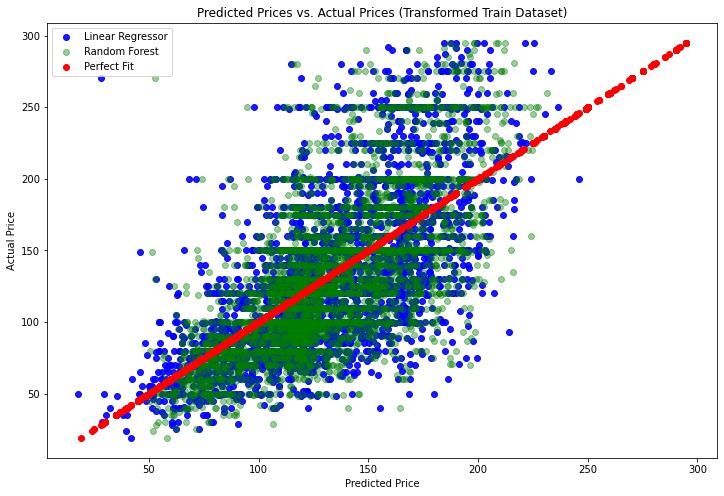

In [122]:
plt.figure(figsize=(12,8))
plt.scatter(pipeline_transformed_LM_grid.predict(X_test_transformed),y_test,color='b', alpha = 0.9, label = 'Linear Regressor')
plt.scatter(pipeline_transformed_RF_grid.predict(X_test_transformed),y_test,color='g', alpha = .4, label = 'Random Forest')
plt.scatter(y_test, y_test, color = 'r', label = 'Perfect Fit')

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.legend(loc='upper left')
plt.title("Predicted Prices vs. Actual Prices (Transformed Train Dataset)")

plt.show()

##### Results of selecting best features manually from a heatmap

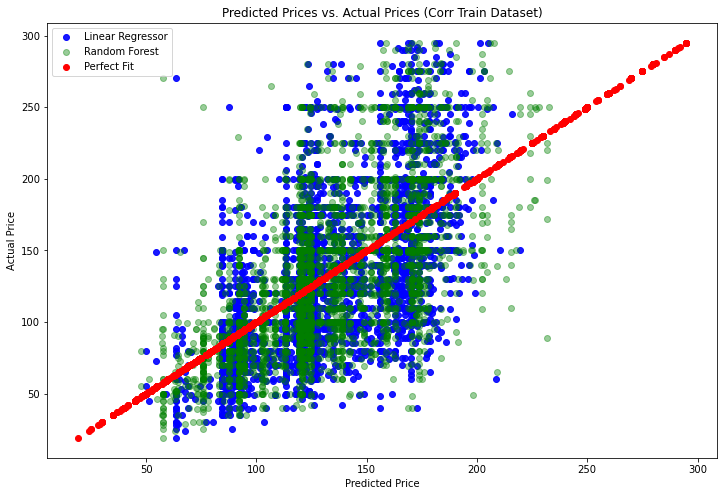

In [124]:
plt.figure(figsize=(12,8))
plt.scatter(pipeline_corr_LM_grid.predict(X_test_corr),y_test,color='b', alpha = 0.9, label = 'Linear Regressor')
plt.scatter(pipeline_corr_RF_grid.predict(X_test_corr),y_test,color='g', alpha = .4, label = 'Random Forest')
plt.scatter(y_test, y_test, color = 'r', label = 'Perfect Fit')

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.legend(loc='upper left')
plt.title("Predicted Prices vs. Actual Prices (Corr Train Dataset)")

plt.show()

The first figure above is a visualization of the predicted prices through the Random Forest Regressor and Linear Regressor  two best performing models on transformed train dataset whereas second plot demonstrates the regression on the corr train dataset.

I am fairly satisfied with the shape of the first plot, with the data generally resembling a pattern of slope 1, which indicates relatively accurate predictions.

Predictions from the models look similar, although the numbers indicate that the Random Forest produced slightly better results. Noticeable differences include the highly concentrated clumping from the Random Forest and Linear Regressor at different intervals, likely due to the model predicting prices at common price points like €85, €100, and €150.

### 5.2 Visualizing Predictive Error

Next, I plotted the error across the different models to see how the difference between prediction and actual prices of listings varied across different parameters. The first scatterplot illustrates how our error changes across listings of different prices on the transforemed train dataset while second plot demontrates error scale on the corr train dataset.

##### Error distribution of the Transformed train dataset prediction

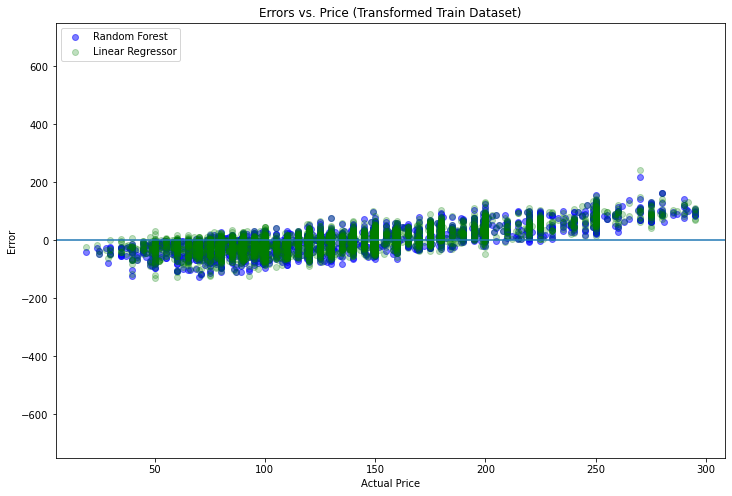

In [130]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,y_test - pipeline_transformed_RF_grid.predict(X_test_transformed),color='b', alpha = .5, label = 'Random Forest')
plt.scatter(y_test,y_test - pipeline_transformed_LM_grid.predict(X_test_transformed),color='g', alpha = .25, label = 'Linear Regressor')
plt.axhline(y = 0)
plt.ylim(-750, 750)
plt.xlabel('Actual Price')
plt.ylabel('Error')
plt.title("Errors vs. Price (Transformed Train Dataset)")
plt.legend(loc='upper left')
plt.show()

##### Error distribution of the Corr train dataset prediction

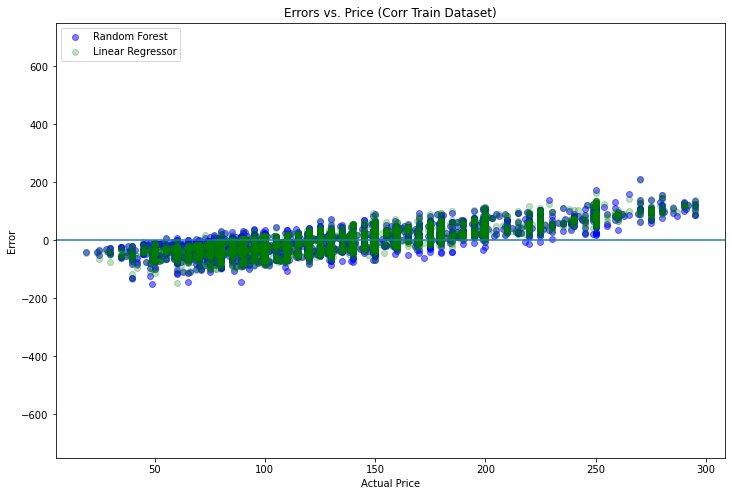

In [132]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,y_test - pipeline_corr_RF_grid.predict(X_test_corr),color='b', alpha = .5, label = 'Random Forest')
plt.scatter(y_test,y_test - pipeline_corr_LM_grid.predict(X_test_corr),color='g', alpha = .25, label = 'Linear Regressor')
plt.axhline(y = 0)
plt.ylim(-750, 750)
plt.xlabel('Actual Price')
plt.ylabel('Error')
plt.title("Errors vs. Price (Corr Train Dataset)")
plt.legend(loc='upper left')
plt.show()

Interesting observations are that models seemed to mispredict similar listings for the both train datasets. You often see pairs of blue and green dots together, indicating that listings that that one model mispredicts, the other model is likely to mispredict as well.